In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [39]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [40]:
print(tf.__version__)

2.17.0


In [41]:
tf.random.set_seed(42)
np.random.seed(42)

In [42]:
train_df = pd.read_csv('Ichijo_train.csv')
val_df = pd.read_csv('Ichijo_val.csv')
test_df = pd.read_csv('Ichijo_test.csv')

print(train_df.shape, val_df.shape, test_df.shape)

(12280, 15) (3509, 15) (1755, 15)


## `DataWindow` class

変数一覧

1.   n_main_generation
2.   n_main_consumption
3.   n_main_buy
4.   n_main_sell
5.   n_main_generated_at_home
6.   n_hems_light
7.   n_hems_air_conditioner
8.   n_hems_eco_cute
9.   n_hems_ih
10.  n_hems_fridge
11.  n_hems_washing
12.  n_hems_ev








今回はn_main_consumption

In [43]:
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
# ここを目的変数ごとに変更
    def plot(self, model=None, plot_col='n_hems_light', max_subplots=3):
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [44]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])

    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])

    return history

In [45]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## Baseline models

In [46]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['n_hems_light'])
#ここも目的関数に

### Repeat last value

In [47]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [48]:
#ここも目的関数に
baseline_last = MultiStepLastBaseline(label_index=column_indices['n_hems_light'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(multi_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(multi_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1115 - mean_absolute_error: 0.2563


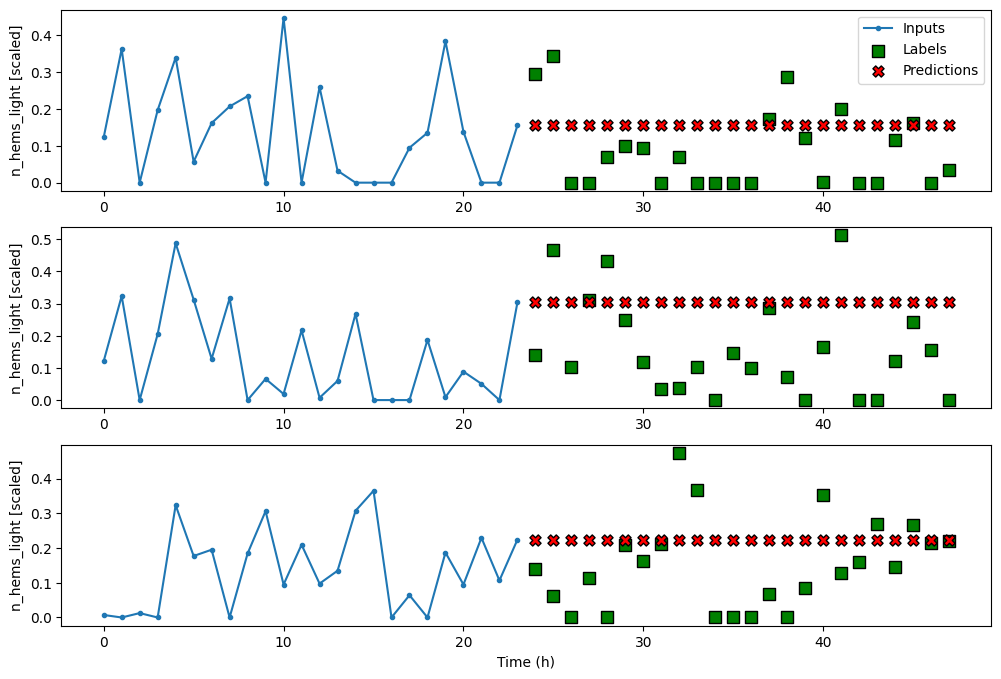

In [49]:
multi_window.plot(baseline_last)

plt.savefig('figures/baseline_last.png', dpi=300)

### Repeat last day

In [50]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [51]:
#ここも目的関数に
baseline_repeat = RepeatBaseline(label_index=column_indices['n_hems_light'])

baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.val)
performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1144 - mean_absolute_error: 0.2587


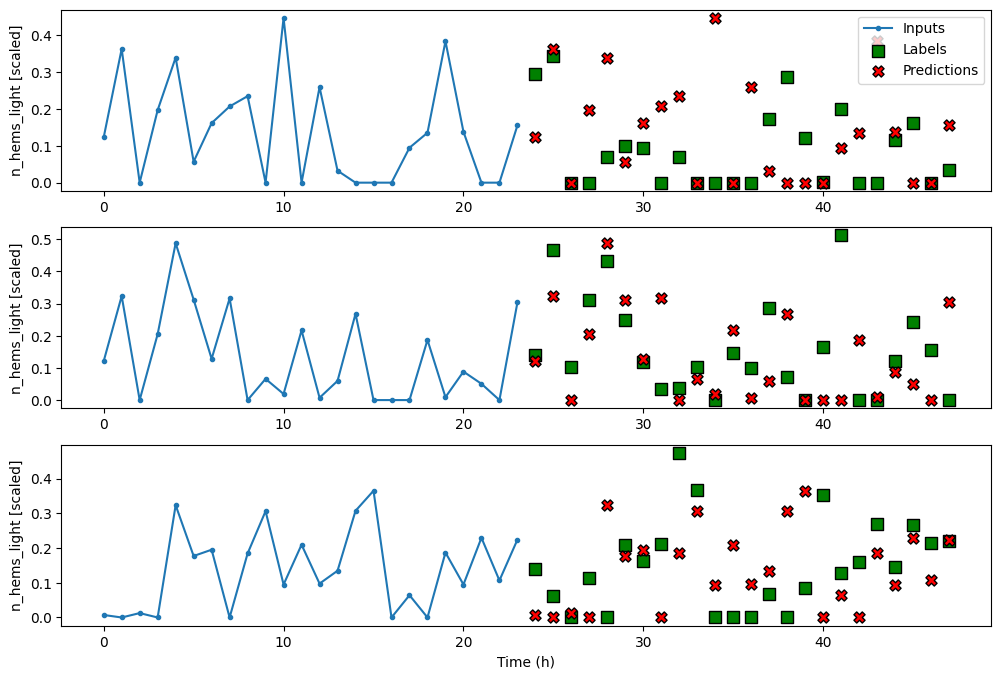

In [52]:
multi_window.plot(baseline_repeat)

plt.savefig('figures/baseline_repeat.png', dpi=300)

## Linear model

In [53]:
#ここも目的関数に
label_index = column_indices['n_hems_light']
num_features = train_df.shape[1]

linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(linear, multi_window)

val_performance['Linear'] = linear.evaluate(multi_window.val)
performance['Linear'] = linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.1942 - mean_absolute_error: 0.6850 - val_loss: 0.0342 - val_mean_absolute_error: 0.1535
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0337 - mean_absolute_error: 0.1467 - val_loss: 0.0339 - val_mean_absolute_error: 0.1521
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0305 - mean_absolute_error: 0.1418 - val_loss: 0.0332 - val_mean_absolute_error: 0.1494
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0329 - mean_absolute_error: 0.1469 - val_loss: 0.3142 - val_mean_absolute_error: 0.5298
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1421 - mean_absolute_error: 0.2588 - val_loss: 0.0639 - val_mean_absolute_error: 0.1961
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2373 - mean_absolute_error: 0.3071 - val_loss: 0.0331 - val_mean_absolute_error: 0.1504
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0473 - mean_absolute_error: 0.1693 -

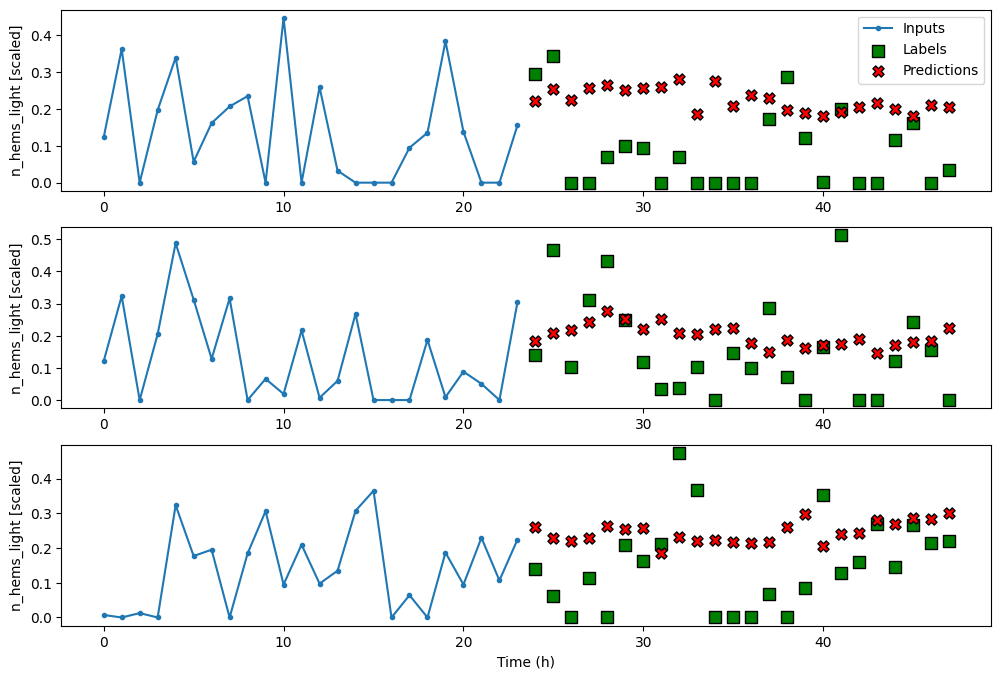

In [54]:
multi_window.plot(linear)

plt.savefig('figures/linear.png', dpi=300)

## Dense model

In [55]:
dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(dense, multi_window)

val_performance['Dense'] = dense.evaluate(multi_window.val)
performance['Dense'] = dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 10.5365 - mean_absolute_error: 1.2336 - val_loss: 0.0529 - val_mean_absolute_error: 0.1947
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0470 - mean_absolute_error: 0.1633 - val_loss: 0.1076 - val_mean_absolute_error: 0.2734
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0901 - mean_absolute_error: 0.2037 - val_loss: 0.0374 - val_mean_absolute_error: 0.1619
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0335 - mean_absolute_error: 0.1460 - val_loss: 0.0335 - val_mean_absolute_error: 0.1517
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0316 - mean_absolute_error: 0.1429 - val_loss: 0.0329 - val_mean_absolute_error: 0.1492
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0303 - mean_absolute_error: 0.1410 - val_loss: 0.0328 - val_mean_absolute_error: 0.1484
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0290 - mean_absolute_error: 0.1392

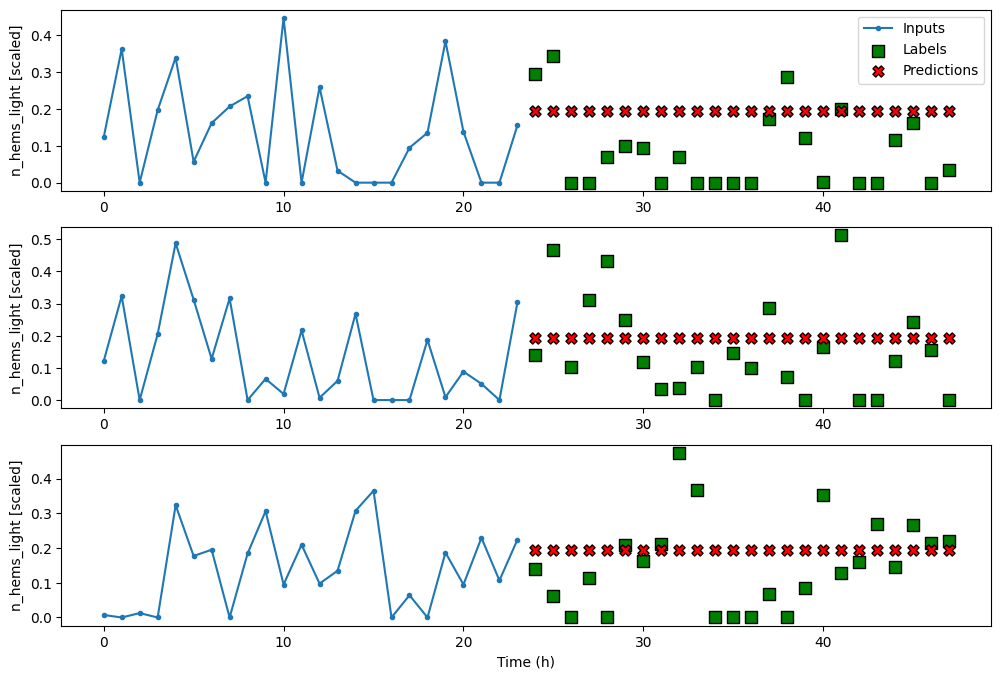

In [56]:
multi_window.plot(dense)

plt.savefig('figures/Dense.png', dpi=300)

## LSTM model

In [57]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, multi_window)

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0308 - mean_absolute_error: 0.1418 - val_loss: 0.0354 - val_mean_absolute_error: 0.1503
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0273 - mean_absolute_error: 0.1369 - val_loss: 0.0348 - val_mean_absolute_error: 0.1495
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0273 - mean_absolute_error: 0.1367 - val_loss: 0.0359 - val_mean_absolute_error: 0.1510
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0272 - mean_absolute_error: 0.1366 - val_loss: 0.0353 - val_mean_absolute_error: 0.1501
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0273 - mean_absolute_error: 0.1368 - val_loss: 0.0352 - val_mean_absolute_error: 0.1499
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0350 - mean_absolute_error: 0.1500


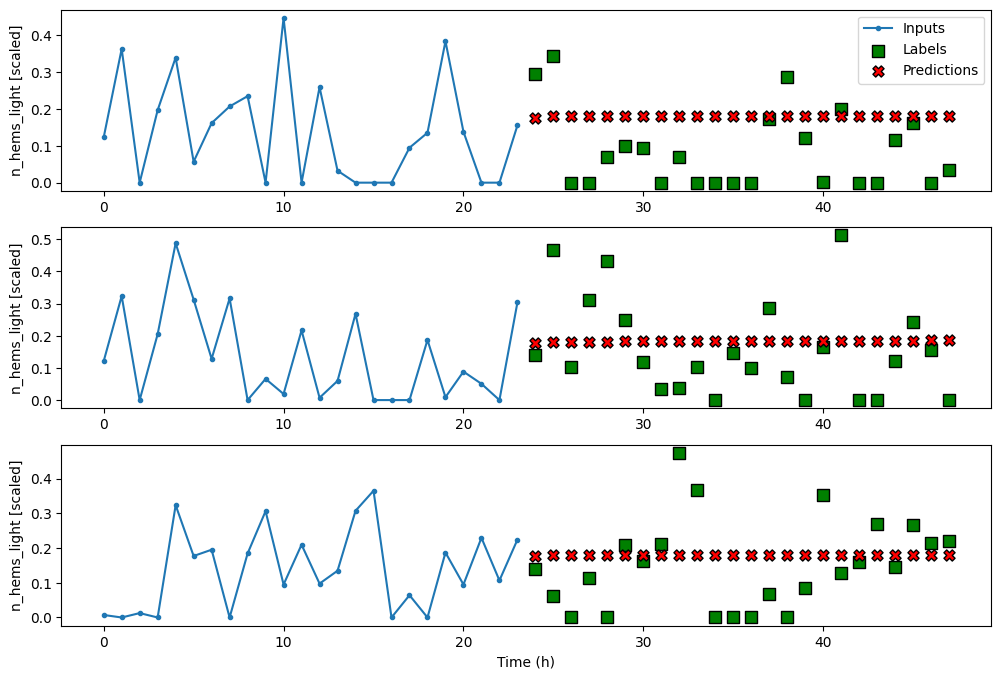

In [58]:
multi_window.plot(lstm_model)

plt.savefig('figures/lstm.png', dpi=300)

## CNN model

In [59]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

cnn_multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['n_hems_light'])
#ここも目的関数に

In [60]:
cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_model, cnn_multi_window)

val_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.val)
performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 5.6181 - mean_absolute_error: 0.9558 - val_loss: 0.0444 - val_mean_absolute_error: 0.1773
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1241 - mean_absolute_error: 0.2225 - val_loss: 0.1627 - val_mean_absolute_error: 0.3602
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0390 - mean_absolute_error: 0.1555 - val_loss: 0.0329 - val_mean_absolute_error: 0.1484
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0323 - mean_absolute_error: 0.1439 - val_loss: 0.0349 - val_mean_absolute_error: 0.1559
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0304 - mean_absolute_error: 0.1409 - val_loss: 0.0356 - val_mean_absolute_error: 0.1576
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0294 - mean_absolute_error: 0.1398 - val_loss: 0.0329 - val_mean_absolute_error: 0.1481
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0285 - mean_absolute_error: 0.1385 -

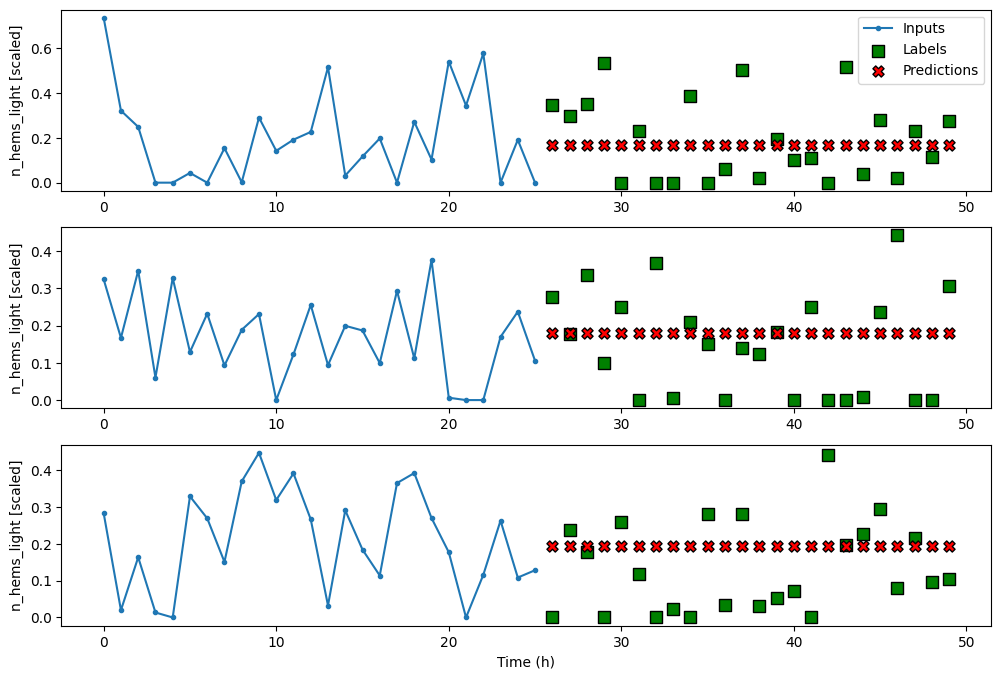

In [61]:
cnn_multi_window.plot(cnn_model)

plt.savefig('figures/CNN.png', dpi=300)

## CNN + LSTM model

In [62]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0326 - mean_absolute_error: 0.1448 - val_loss: 0.0342 - val_mean_absolute_error: 0.1488
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0280 - mean_absolute_error: 0.1386 - val_loss: 0.0341 - val_mean_absolute_error: 0.1487
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0280 - mean_absolute_error: 0.1386 - val_loss: 0.0340 - val_mean_absolute_error: 0.1486
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0279 - mean_absolute_error: 0.1385 - val_loss: 0.0337 - val_mean_absolute_error: 0.1483
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0279 - mean_absolute_error: 0.1386 - val_loss: 0.0336 - val_mean_absolute_error: 0.1482
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0279 - mean_absolute_error: 0.1385 - val_loss: 0.0338 - val_mean_absolute_error: 0.1484
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0279 - mean_absolute_error: 0

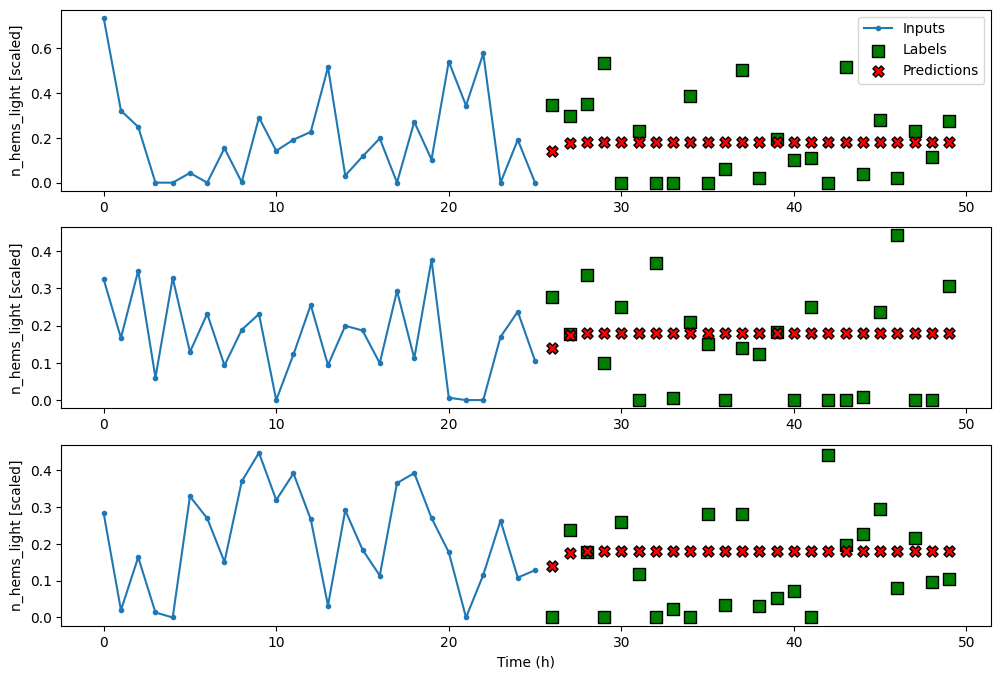

In [63]:
cnn_multi_window.plot(cnn_lstm_model)

plt.savefig('figures/CNN+lstm.png', dpi=300)

## Autoregressive LSTM

In [64]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])

    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)

        return prediction, state

    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)

        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)

            prediction = self.dense(x)
            predictions.append(prediction)

        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])

        return predictions

In [65]:
AR_LSTM = AutoRegressive(units=32, out_steps=24)

history = compile_and_fit(AR_LSTM, multi_window)

val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 0.0483 - mean_absolute_error: 0.1676 - val_loss: 0.0351 - val_mean_absolute_error: 0.1500
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 0.0276 - mean_absolute_error: 0.1376 - val_loss: 0.0344 - val_mean_absolute_error: 0.1490
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0276 - mean_absolute_error: 0.1375 - val_loss: 0.0346 - val_mean_absolute_error: 0.1493
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0274 - mean_absolute_error: 0.1371 - val_loss: 0.0369 - val_mean_absolute_error: 0.1524
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.0274 - mean_absolute_error: 0.1371 - val_loss: 0.0348 - val_mean_absolute_error: 0.1496
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0351 - mean_absolute_error: 0.1501


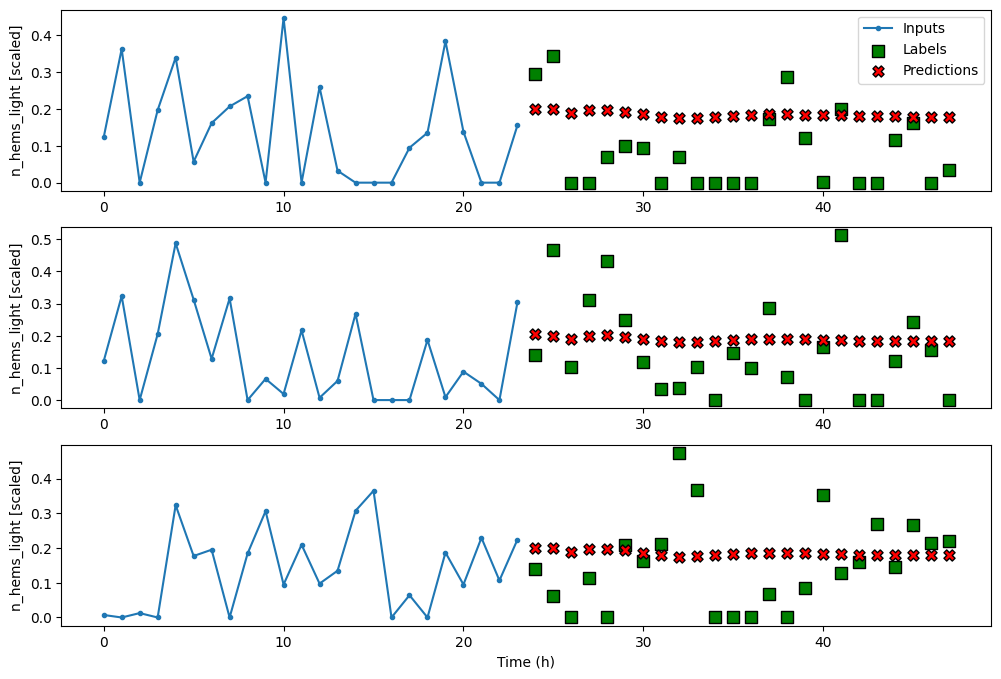

In [66]:
multi_window.plot(AR_LSTM)

plt.savefig('figures/AR_LSTM_n_hems_light.png', dpi=300)

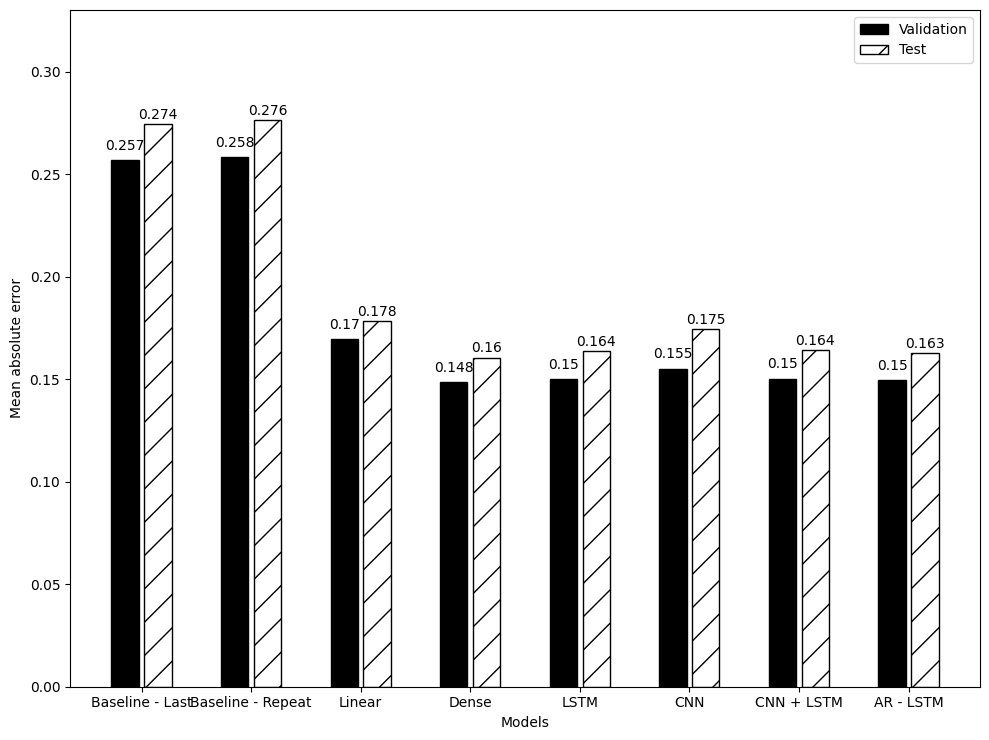

In [67]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.005, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.33)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/Validation_Compersion_n_hems_light.png', dpi=300)